# Test of running the code for several dates

*JASaa*

*PIE017 ISAE-SUPAERO*

## Load data and import functions

In [1]:
from eddies import load_netcdf4,eddy_detection,print_eddies,plot_eddies

#name of the netCDF data file
filename = 'Lebreton_2015.nc'

# load data
(f,lon,lat,depth,uvel,vvel,t) =  load_netcdf4(filename)

# Confidence level, usually 90%
R2_criterion = 0.9
# OW value at which to begin the evaluation of R2
OW_start = -1.0
# Number of local minima to evaluate using R2 method.
# Set low (like 20) to see a few R2 eddies quickly.
# Set high (like 1e5) to find all eddies in domain.
max_evaluation_points = 2000 #set to 2000 to capture avery minima, there should be around 1800
# Minimum number of cells required to be identified as an eddie.
min_eddie_cells = 3 # set to 3 to be coherent with the use of the R2 method, 3 points seems like a reasonable minimun for a correlation 
# z-level to plot.  Usually set to 0 for the surface.
k_plot = 0

## Run code for several days
Run this cell to generate data for every day
- **eddy_data** is a list of len(t) (or 92 elements for the Lebreton2015 data) tuples 
    *(lon,lat,uvel,vvel,vorticity,OW,OW_eddies,eddie_census,nEddies,circulation_mask)* 
- *lon,lat,uvel,vvel* are not in the same format as the original netcdf data, they are transposed and only for one day
- *circulation_mask* has the circulation for each cell such that circulation_mask = circ(lon,lat). The circulation is constant in an eddy and 0 outside of any eddy
    - circ>0 : cyclonic eddy
    - circ<0 : anti-cyclonic eddy
    - circ=0 :  no eddy
    
To know more about each output, refer to the comments at the top of **eddies.py**

In [2]:
%%capture

eddy_data = []
for day in range(len(t)):
    eddy_data.append(eddy_detection(lon,lat,depth,uvel,vvel,day,R2_criterion,OW_start,max_evaluation_points,min_eddie_cells)) 
    #list: lon,lat,uvel,vvel,vorticity,OW,OW_eddies,eddie_census,nEddies,circulation_mask

### Example : to acces the circulation mask for each day and store it in a list

In [3]:
import numpy as np

nEd = np.zeros(len(t),dtype=int)
n_cyclonic = np.zeros(len(t),dtype=int)
eddy_census_list = []
mask_circulation_list = []
for day in range(len(t)):
    nEd[day] = eddy_data[day][8] #count the number of eddies for each day with circ>0 for each day
    eddy_census_list.append(eddy_data[day][7]) #store all eddy_census in a list
    n_cyclonic[day] = sum(circ > 0. for circ in eddy_census_list[day][1]) #count the number of eddies with circ>0 for each day
    mask_circulation_list.append(eddy_data[day][9]) #list of circulation masks

In [25]:
day0 = 1
print_eddies(eddy_census_list[day0],nEd[day0])


Eddie census data

         minOW  circ(m^2/s)      lon(º)     lat(º)  cells  diameter(km)
1    -1.440708 -4534.861787 -136.583328  39.250000  247.0    145.498521
2    -2.891690  3650.176960 -128.583328  40.416668   60.0     71.299247
3    -1.579805  3239.589177 -137.250000  41.750000   44.0     60.692259
4    -1.054645  2059.591098 -156.333328  36.916668   48.0     65.564131
5    -1.156096 -2631.568082 -136.416672  28.000000   57.0     74.928708
6    -1.394046  2828.654832 -142.416672  26.250000   33.0     57.811793
7    -3.385552  3899.280051 -136.333328  41.333332  135.0    105.631622
8    -1.173219  2056.299107 -137.083328  33.666668    4.0     21.346444
9    -4.209669  7194.929336 -125.416664  41.416668  173.0    119.481611
10   -2.571041 -4807.849527 -125.250000  30.000000  111.0    103.295787
11   -1.868243  2915.936895 -135.416672  27.250000   29.0     54.045301
12   -1.679409  2797.712701 -135.333328  29.833334   46.0     66.780369
13   -2.499656 -5381.314290 -127.833336  40.

## Example of some interesting post-processing
Similar plot to the Petersen2013 paper

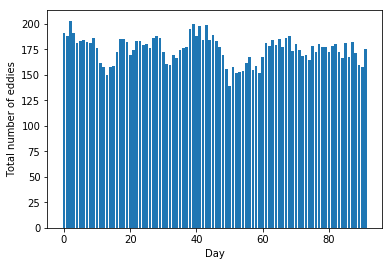

In [5]:
#number of eddies vs day
import matplotlib.pyplot as plt
import numpy as np

plt.bar(np.arange(len(t)),nEd)
plt.ylabel('Total number of eddies')
plt.xlabel('Day')
plt.show()

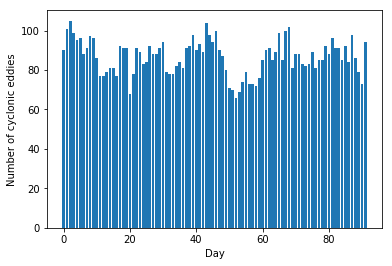

In [6]:
#number of cyclonic eddies vs day
import matplotlib.pyplot as plt
import numpy as np

plt.bar(np.arange(len(t)),n_cyclonic)
plt.ylabel('Number of cyclonic eddies')
plt.xlabel('Day')
plt.show()

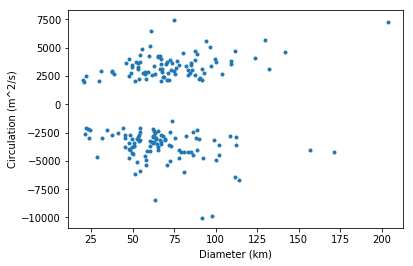

In [7]:
#plot of circulation vs diameter for a certain day
import matplotlib.pyplot as plt

day0 = 0 

plt.plot(eddy_census_list[day0][5,:nEd[day0]],eddy_census_list[day0][1,:nEd[day0]],'.')
plt.xlabel('Diameter (km)')
plt.ylabel('Circulation (m^2/s)')
plt.show()

### We put map_circulation in the same format as the original uvel, vvel, etc; that we took from the netcdf data.

In [8]:
# We turn the list into an ndarray like uvel, 
map_circulation = np.asarray(mask_circulation_list)
map_circulation.shape

(92, 385, 205, 1)

In [9]:
# The shape that we need
uvel.shape

(92, 1, 205, 385)

In [10]:
# Transpose to the new shape
map_circulation_final = map_circulation.transpose(0,3,2,1)
map_circulation_final.shape

(92, 1, 205, 385)

## Save the data into *.npy* files

In [24]:
np.save("eddy_data", eddy_data)
np.save("map_circulation", map_circulation_final[:,0,:,:]) #omit depth because there is only one
np.save("nEd", nEd)
np.save("n_cyclonic", n_cyclonic)

## To load them
They will load as an numpy array and not a list.

In [42]:
map_circulation2 = np.load("map_circulation.npy")
map_circulation2.shape

(92, 205, 385)

### We can also pretty print the dates
It might be useful...

In [39]:
import datetime

def julianh2gregorian(time_hours,origin):
    return origin + datetime.timedelta(hours=time_hours)

origin_julian = datetime.date(1950, 1, 1) 

gregorian_dates = []
gregorian_str = []
for i in range(len(t)):
    gregorian_dates.append(julianh2gregorian(t[i],origin_julian))
    gregorian_str.append(str(gregorian_dates[i]))

print(gregorian_str)

['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11', '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15', '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19', '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31', '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16', '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20', '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24', '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28', '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01', '2015-09-02', '2015-09-03', '2015-09-04', '2015-09-05', '2015-09-06', '2015-09-07', '2015-09-08', '2015-09-09', '2015